In [1]:
import logging

import pandas as pd
import sklearn
import random
import wandb
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from simpletransformers.classification import (
    ClassificationArgs1,
    ClassificationModel1,
)

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [2]:
df = pd.read_csv('pos_sent.csv')
df = df.drop(columns=['bi_labels'])
df['title'] = df['main_heading'] + ': ' + df['heading']
df.loc[((df['main_heading'] == df['heading']) | (pd.isnull(df['heading']))), 'title'] = df['main_heading']
df['title'] = df['title'].fillna('')
df['labels']='results'

In [3]:
label_list = ['results',
               'ablation-analysis',
               'method',
               'baselines',
               'dataset',
               'hyper-setup',
               'experiments',
               'research-problem',
               'tasks']

In [4]:
model_args = ClassificationArgs1()

model_args.labels_list = label_list
model_args.normalize_ofs = True
model_args.overwrite_output_dir = True
model_args.reprocess_input_data = True
model_args.manual_seed = 1
model_args.fp16 = False
model_args.use_multiprocessing = True
model_args.do_lower_case = True  # when using uncased model

In [5]:
model = ClassificationModel1(
    "bert",
    "../sent/Moutputs/best_model",
    num_labels=9,
    args=model_args,
)

INFO:simpletransformers.classification.classification_model1: Converting to features started. Cache is not used.


  0%|          | 0/2720 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/340 [00:00<?, ?it/s]

/opt/conda/envs/hl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/hl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/hl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

          results       1.00      0.27      0.42      2720
ablation-analysis       0.00      0.00      0.00         0
           method       0.00      0.00      0.00         0
        baselines       0.00      0.00      0.00         0
          dataset       0.00      0.00      0.00         0
      hyper-setup       0.00      0.00      0.00         0
      experiments       0.00      0.00      0.00         0
 research-problem       0.00      0.00      0.00         0
            tasks       0.00      0.00      0.00         0

         accuracy                           0.27      2720
        macro avg       0.11      0.03      0.05      2720
     weighted avg       1.00      0.27      0.42      2720

[[729 145 601 116  21 439 242 401  26]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  

/opt/conda/envs/hl/lib/python3.9/site-packages/sklearn/metrics/_classification.py:870: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
INFO:simpletransformers.classification.classification_model1:{'mcc': 0.0, 'F1_score': 0.046970136271383, 'eval_loss': 5.824587880314657}


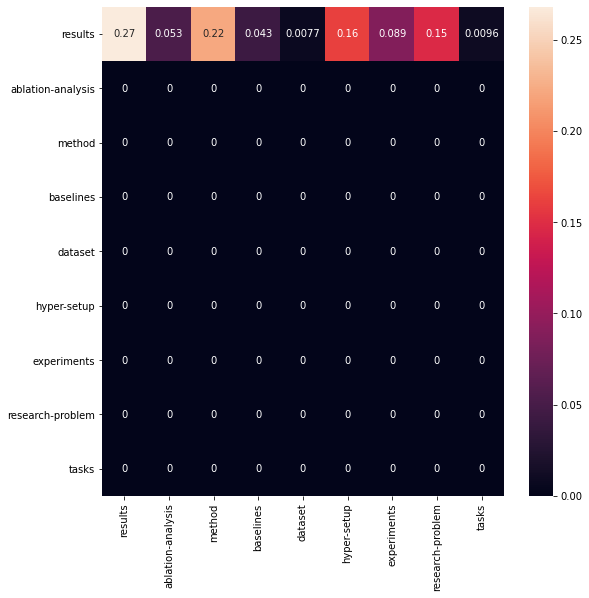

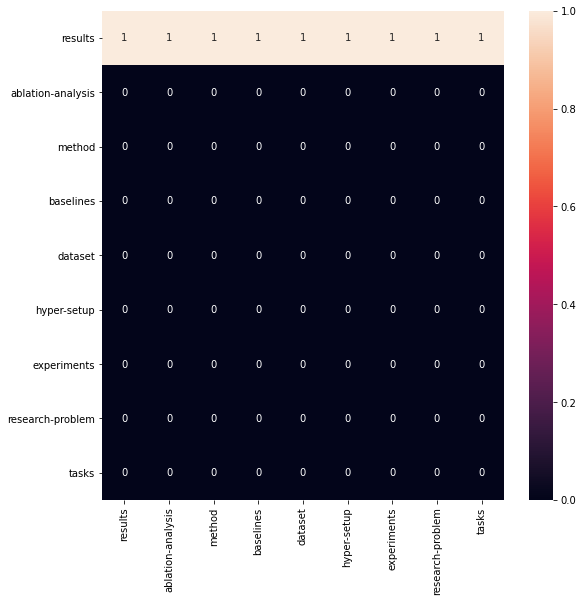

In [6]:
def F1_score(ref, pred):
    print(classification_report(ref, pred, target_names=label_list))
    cm = confusion_matrix(ref, pred, labels=np.arange(9), normalize=None)
    print(cm)
    cm = confusion_matrix(ref, pred, labels=np.arange(9), normalize='true')
    cm = cm.tolist()
    df_cm = pd.DataFrame(cm, index = label_list, columns = label_list)
    plt.figure(figsize = (9,9))
    sn.heatmap(df_cm, annot=True)
    
    cm = confusion_matrix(ref, pred, labels=np.arange(9), normalize='pred')
    cm = cm.tolist()
    df_cm = pd.DataFrame(cm, index = label_list, columns = label_list)
    plt.figure(figsize = (9,9))
    sn.heatmap(df_cm, annot=True)
    return sklearn.metrics.f1_score(ref, pred, labels=np.arange(9), average='macro')

result, model_outputs, wrong_predictions = model.eval_model(df, F1_score=F1_score)

In [7]:
preds = list(model_outputs.argmax(axis=1))
preds = [label_list[p] for p in preds]
df['labels']=preds
df['paper']=df['topic']+df['paper_idx'].astype(str)

In [8]:
def classify_method(df): # df should contain sentences from the same paper
    headings = ''.join(str(heading).lower() for heading in df['main_heading'].unique())
    if 'model' in headings:
        return 'model'
    elif 'approach' in headings:
        return 'approach'
    text = ''.join(df['text']).lower()
    if 'system' in text or 'architecture' in text:
        return 'model'
    if 'approach' in text and \
        not ('existing approach' in text or 'previous approach' in text or 'former approach' in text):
        return 'approach'
    return 'model'

terms = set(['keras', 'pytorch', 'torch', 'tensorflow', 'theano', 'cuda', 'cpu', 'cpus',
              'gpu', 'gpus', 'nvidia', 'intel', 'gtx', 'geforce', 'tesla','titan',
             'nltk', 'spacy', 'corenlp', 'stanford', 'tokenizer',
              'run'])

def classify_hyper_setup(df): # df should contain sentences from the same paper
    df=df[df['labels']=='hyper-setup']
    text=' '.join(list(df['text'].values))
    if len(terms.intersection(set(text.lower().split()))) > 0:
        return 'experimental-setup'
    else:
        return 'hyperparameters'

def judge_code(s):
    s=s.lower()
    if 'github.' in s or 'github .' in s:
        return 1
    elif ('https:' in s or 'http:' in s) and ('available' in s or 'code' in s):
        return 1
    else:
        return 0

In [9]:
df1=df[df['labels']=='method']
paper_ls=list(df1['paper'].unique())
for paper in paper_ls:
    df.loc[(df['paper']==paper)&(df['labels']=='method'),'labels']=classify_method(df[df['paper']==paper])

In [10]:
df2=df[df['labels']=='hyper-setup']
paper_ls=list(df2['paper'].unique())
for paper in paper_ls:
    df.loc[(df['paper']==paper)&(df['labels']=='hyper-setup'),'labels']=classify_hyper_setup(df[df['paper']==paper])

In [11]:
for i in range(len(df)):
    if judge_code(df.iloc[i,1])==1:
        df.at[i,'labels']='code'

In [12]:
from collections import Counter
Counter(df['labels'].values)

Counter({'research-problem': 388,
         'model': 541,
         'hyperparameters': 226,
         'experimental-setup': 207,
         'tasks': 26,
         'results': 728,
         'experiments': 240,
         'approach': 57,
         'ablation-analysis': 144,
         'dataset': 13,
         'baselines': 115,
         'code': 35})

In [13]:
df.to_csv('pos_sent.csv', index=False)